# Part 2 - Model building and selection

This notebook is part 2 of the capstone project from the [IBM AI Enterprise Workflow specialization](https://www.coursera.org/specializations/ibm-ai-workflow). The main goal here is to compare different models to predict revenue, given the [data](https://github.com/aavail/ai-workflow-capstone), and select one to be put into production.

Author: Rafael da Ponte Barbosa

In [150]:
import pandas as pd
import numpy as np
import os
#import re
#import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet

from sklearn.metrics import mean_squared_error

plt.style.use('seaborn')

from application.utils.ingestion import fetch_data,fetch_ts
from application.utils.processing import convert_to_ts, engineer_features

from application.utils.plot import ts_plot, ts_plot_pred

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
data_dir = os.path.join("data","cs-train")
ts_data = fetch_ts(data_dir)

... loading ts data from files


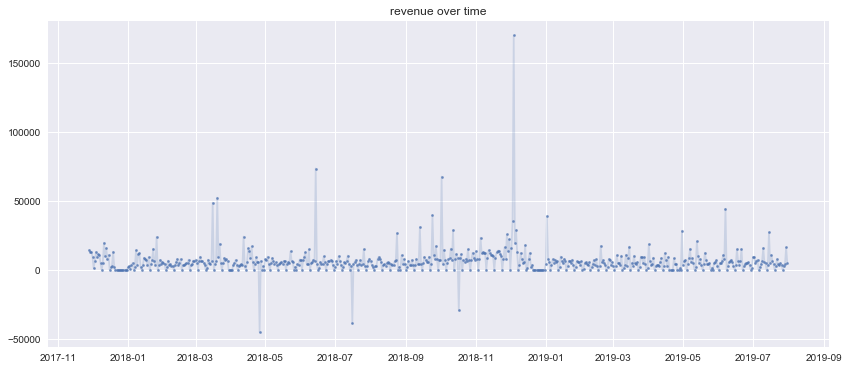

In [87]:
ts_plot(ts_data['all'].date, ts_data['all'].revenue,figx=14,figy=6, title="revenue over time")

## Baseline

We'll employ a simple moving average as the baseline for forecasting, and we'll use MSE as the optimization metric. Note that is is closely related to the business problem: if we want to predict revenue over time, a low MSE indicates good accuracy. To keep things simple, we'll compare model performances for all data points and for the 3 top countries (w.r.t revenue): UK, EIRE and Germany. For all, we use a simple train/test split over time, where the last 30 data points are kept as test, while the remaining ones are used for training.

For the moving average, we compare three time windows.: 7, 14 and 28; we conclude, by observing the errors, that the latter performs the best.

In [129]:
windows = [7,14,28]
keys = ['all', 'united_kingdom', 'eire', 'germany']
results = []

for window in windows:
    print("Using window {}".format(window))
    mse = []
    
    for key in keys:
        df = ts_data[key]
        df_train = ts_data[key][:-30]
        df_test = ts_data[key][-30:].copy()

        y_pred = df_train.revenue.values

        for date in df_test.date:
            y_pred = np.append(y_pred, np.mean(y_pred[-window:]))

        df_test['pred'] = y_pred[-30:]
        
        mse.append(mean_squared_error(df_test.revenue, df_test.pred))

    results.append(np.mean(mse))
    print("Average MSE: {}".format(results[-1]))
    

Using window 7
Average MSE: 16595181.022210326
Using window 14
Average MSE: 15829939.271474602
Using window 28
Average MSE: 14897365.436453233


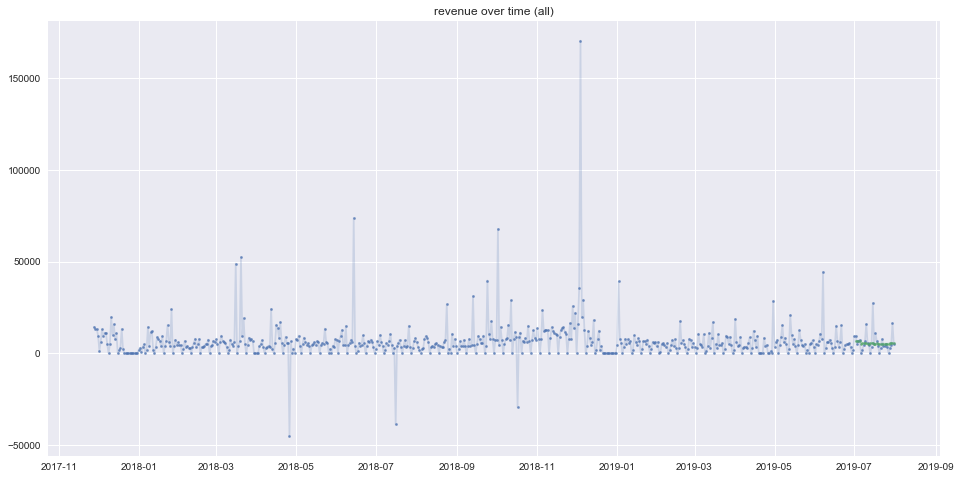

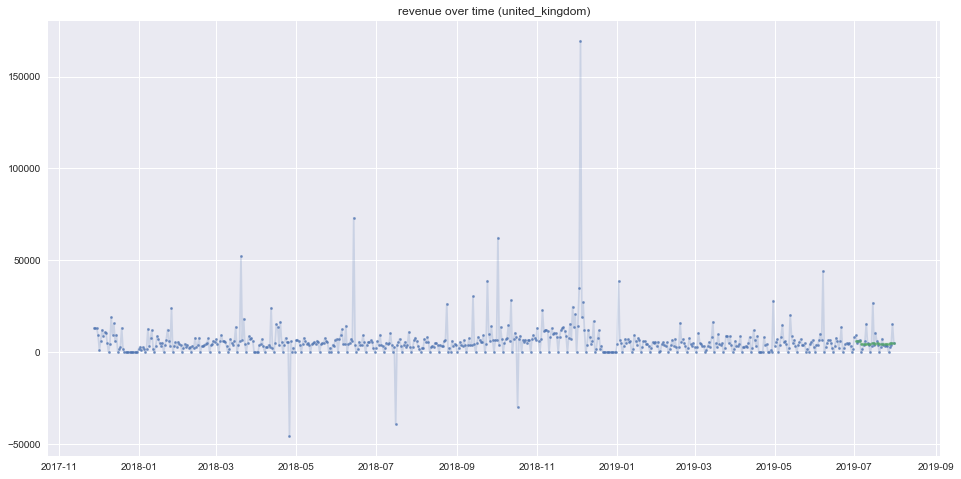

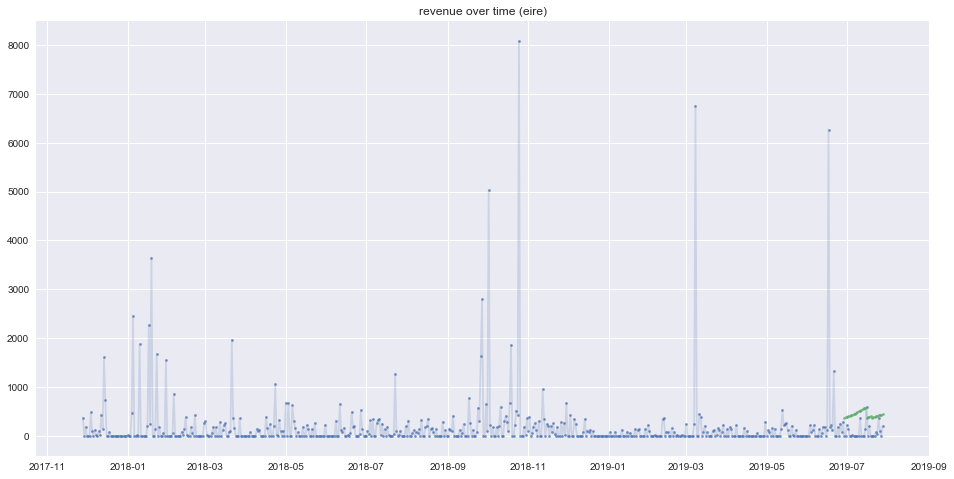

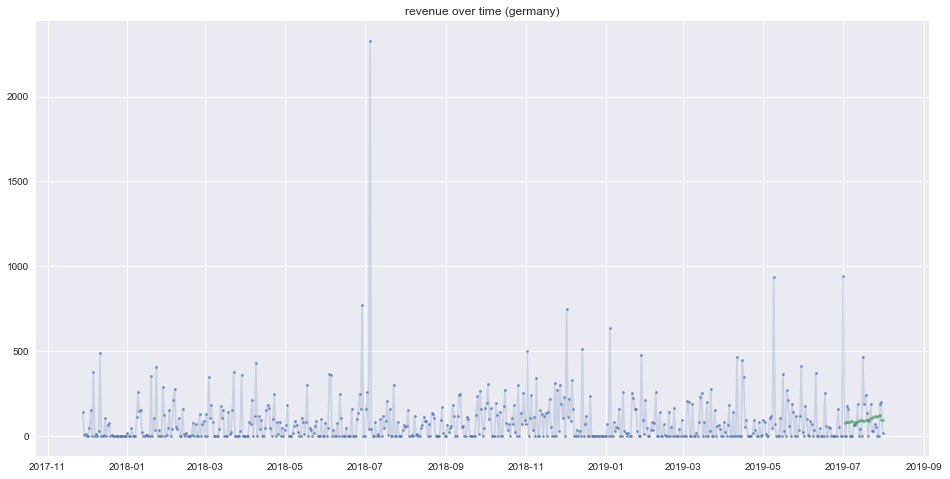

In [324]:
window = 28
keys = ['all', 'united_kingdom', 'eire', 'germany']
mse_baseline = {}
y_pred = {}

for key in keys:
    df = ts_data[key].copy(deep=True)
    df_train = df[:-30]
    df_test = df[-30:].copy()
    
    y_pred[key] = df_train.revenue.values

    for date in df_test.date:
        y_pred[key] = np.append(y_pred[key], np.mean(y_pred[key][-window:]))

    df_test['pred'] = y_pred[key][-30:]
    
    mse_baseline[key] = mean_squared_error(df_test.revenue, df_test.pred)
    
    ts_plot_pred(df.date, df.revenue,\
         df[-30:].date, y_pred[key][-30:], figx=16,figy=8, title="revenue over time ({})".format(key))

## Prophet

In [ ]:
keys = ['all', 'united_kingdom', 'eire', 'germany']
y_pred = {}
mse_prophet = {}

for key in keys:
    df = ts_data[key][['date', 'revenue']].copy(deep=True)
    df.rename(columns={'date':'ds', 'revenue': 'y'},inplace=True)

    df_train = df[:-30]
    df_test = df[-30:]
    
    m = Prophet(weekly_seasonality=True)  
    m.fit(df_train)
    
    y_pred[key] = m.predict(df_test)
    
    mse_prophet[key] = mean_squared_error(df_test.y, y_pred[key].yhat)
    
    ts_plot_pred(df.ds, df.y,\
             df[-30:].ds, y_pred[key][-30:].yhat, figx=16,figy=8, title="revenue over time ({})".format(key))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [323]:
for key in keys:
    if (mse_baseline[key] > mse_prophet[key]):
        print("{}: prophet performed better than baseline ({} vs {})".format(key,mse_rf[key],mse_prophet[key]))
    else:
        print("{}: prophet performed worse than baseline ({} vs {})".format(key,mse_rf[key],mse_prophet[key]))

print()
print("Average MSE for baseline: {}".format(np.mean([val for _,val in mse_baseline.items()])))
print("Average MSE for prophet: {}".format(np.mean([val for _,val in mse_prophet.items()])))

all: prophet performed better than baseline (40050399.46009139 vs 25595969.460585415)
united_kingdom: prophet performed better than baseline (54846373.54647672 vs 26191175.56259271)
eire: prophet performed better than baseline (22201.88755034419 vs 27147.44711638386)
germany: prophet performed better than baseline (79888.80183258801 vs 8792.919264268467)

Average MSE for baseline: 14897365.436453233
Average MSE for prophet: 12955771.347389696


## Supervised learning model

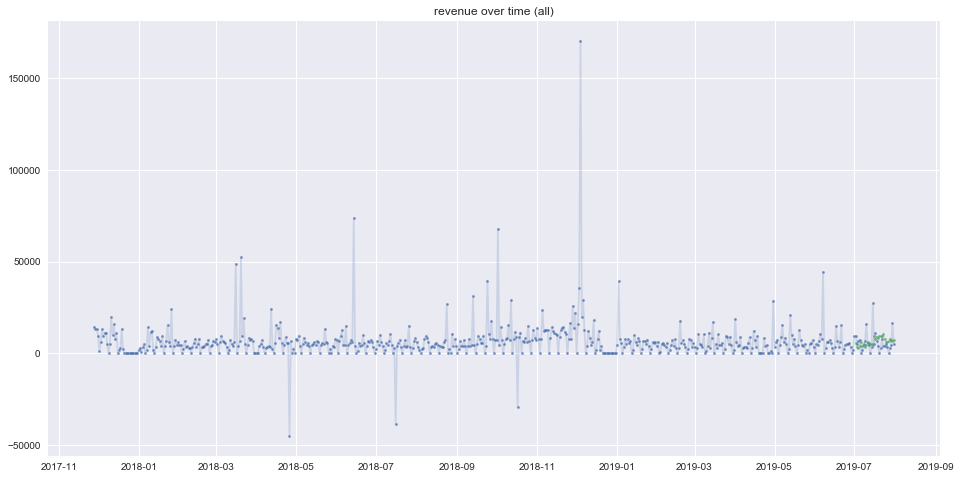

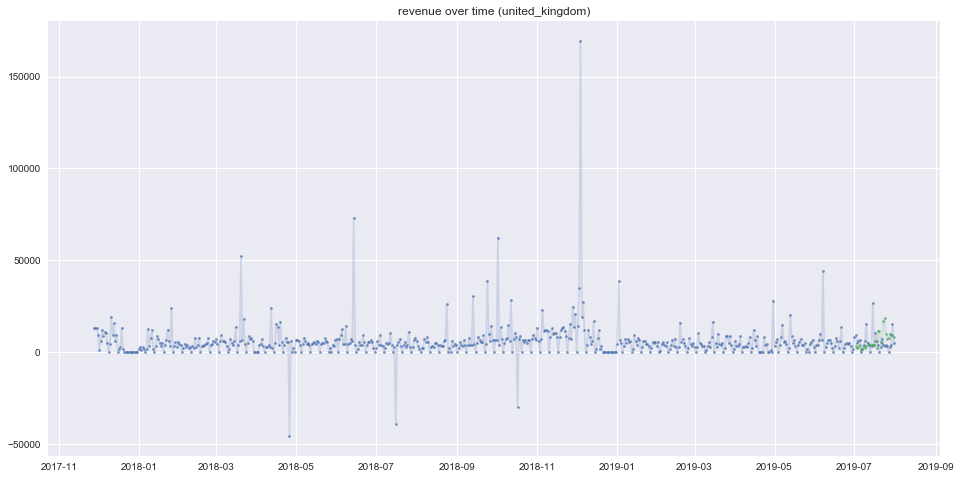

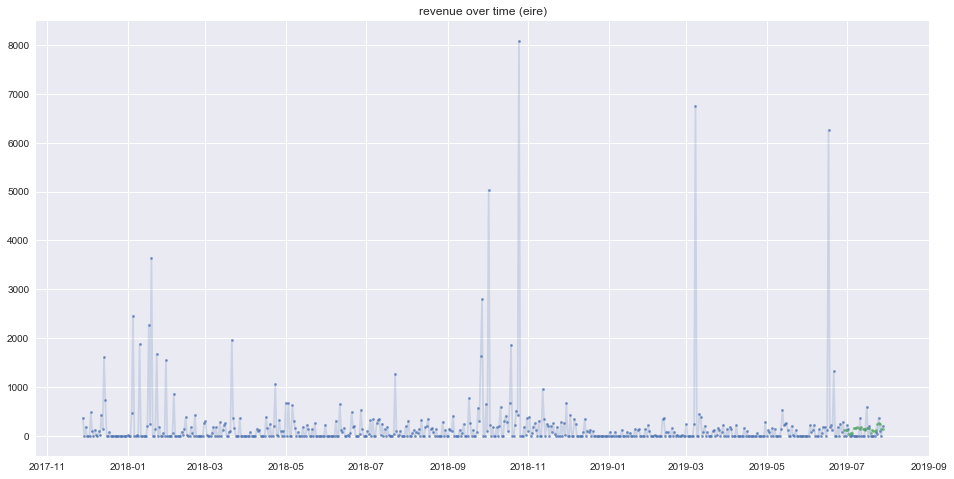

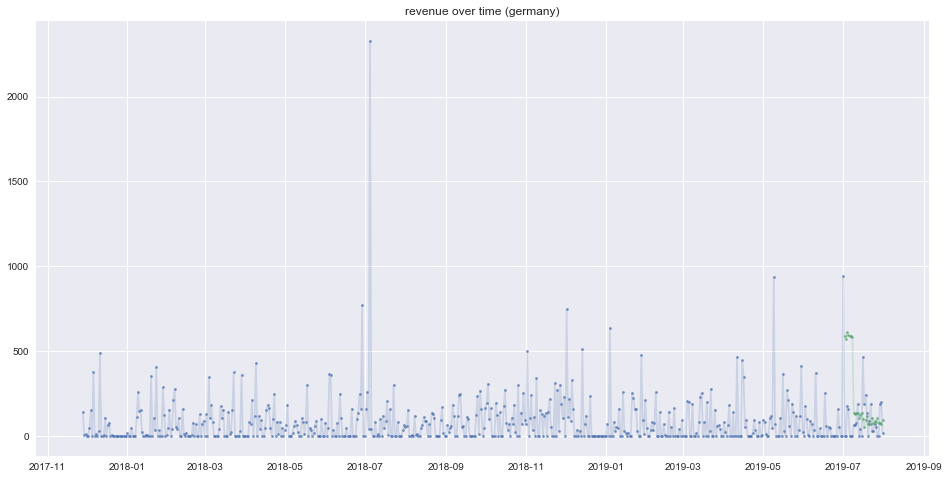

In [311]:
keys = ['all', 'united_kingdom', 'eire', 'germany']
y_pred = {}
mse_rf = {}

for key in keys:
    df = ts_data[key]
    X,y,dates = engineer_features(df)

    X_train = X[:-30].drop(columns=['day'])
    X_test = X[-30:].drop(columns=['day'])
    y_train = y[:-30]
    y_test = y[-30:]
    
    pipe_rf = Pipeline(steps=[('scaler', StandardScaler()),
                              ('rf', RandomForestRegressor())])
    pipe_rf.fit(X_train,y_train)
    
    y_pred[key] = pipe_rf.predict(X_test)
    
    mse_rf[key] = mean_squared_error(y_test, y_pred[key])
    
    ts_plot_pred(df.date, df.revenue,\
             df[-30:].date, y_pred[key], figx=16,figy=8, title="revenue over time ({})".format(key))

In [319]:
[val for _,val in mse_rf.items()]

[40050399.46009139, 54846373.54647672, 22201.88755034419, 79888.80183258801]

In [321]:
for key in keys:
    if (mse_prophet[key] > mse_rf[key]):
        print("{}: RF performed better than prophet ({} vs {})".format(key,mse_rf[key],mse_prophet[key]))
    else:
        print("{}: RF performed worse than prophet ({} vs {})".format(key,mse_rf[key],mse_prophet[key]))

print()
print("Average MSE for RF: {}".format(np.mean([val for _,val in mse_rf.items()])))
print("Average MSE for prophet: {}".format(np.mean([val for _,val in mse_prophet.items()])))

all: RF performed worse than prophet (40050399.46009139 vs 25595969.460585415)
united_kingdom: RF performed worse than prophet (54846373.54647672 vs 26191175.56259271)
eire: RF performed better than prophet (22201.88755034419 vs 27147.44711638386)
germany: RF performed worse than prophet (79888.80183258801 vs 8792.919264268467)

Average MSE for RF: 23749715.923987757
Average MSE for prophet: 12955771.347389696
